In [1]:
%matplotlib notebook

# %qtconsole

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes as qc
from qcodes.dataset.experiment_container import new_experiment

In [2]:
from pytopo.qctools import instruments as instools
from pytopo.qctools.instruments import create_inst, add2station

from pytopo.sweep.base import Nest, Chain
from pytopo.sweep.decorators import getter, setter
from pytopo.sweep import sweep, do_experiment, hardsweep, measure

# Define measurement functions

In [3]:
def setup_frq_sweep(fstart, fstop, fpts, chan='S21', bw=None, navgs=None, pwr=None):
    """
    Setup a VNA trace.
    
    assumes that a channel with name chan is already created.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(fstart, fstop, fpts)
    trace.start(fstart)
    trace.stop(fstop)
    trace.npts(fpts)
    if navgs is not None:
        trace.avg(navgs)
    if bw is not None:
        trace.bandwidth(bw)
    if pwr is not None:
        trace.power(pwr)
    trace.autoscale()
    
    if not vna.rf_power():
        vna.rf_on()
    
    return fvals

def take_trace(chan='S21', plot=False):
    """
    Get the data of a currently measured trace.
    The trace has to be setup already.
    
    Returns magnitude (in dB) and phase (in rad).
    
    If plot is true, make a simple plot of the magnitude vs frequency.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    fvals = np.linspace(trace.start(), trace.stop(), trace.npts())
    mag, phase = trace.trace_mag_phase()
    
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(fvals*1e-9, 20*np.log10(mag))
        ax.grid(dashes=[1,1])
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Magnitude (dBm)')
        
    return mag, phase


def setup_zerospan_trace(frq, npts, chan='S21', span=1.):
    """
    Setup the VNA to measure a trace around <frq> with <npts> samples
    in a very narray frequency span.
    """
    vna = qc.Station.default.vna
    trace = getattr(vna.channels, chan)
    
    trace.center(frq)
    trace.span(span)
    trace.npts(npts)
    
    trace.autoscale()
    
    if not vna.rf_power():
        vna.rf_on()

        
### pytopo.sweep measurement functions

@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('amplitude', '', 'array'), ('phase', 'rad', 'array')]
)
def vna_frequency_sweep(*arg, **kw):
    """
    Measurement function for a simple VNA trace for pytopo.sweep.
    
    All arguments will be passed to setup_trace.
    Return data is as returned by take_trace.
    """
    fvals = setup_frq_sweep(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return fvals, np.vstack((mag, phase))

@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('magnitude', 'dB', 'array'), ('phase', 'rad', 'array')]
)
def vna_frequency_sweep_dB(*arg, **kw):
    """
    Measurement function for a simple VNA trace for pytopo.sweep.
    
    All arguments will be passed to setup_trace.
    Return data is as returned by take_trace.
    """
    fvals = setup_frq_sweep(*arg, **kw)
    mag, phase = take_trace(plot=False)
    time.sleep(1)
    
    return fvals, np.vstack((20*np.log10(mag), phase))

@hardsweep(
    ind=[('iteration', '', 'array')], 
    dep=[('amplitude', '', 'array'), ('phase', 'rad', 'array')]
)
def vna_timetrace(*arg, **kw):
    """
    Measure a 'time trace', emulated by a narrow span trace with many points.
    """
    setup_zerospan_trace(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return np.arange(mag.size), np.vstack((mag, phase))


@hardsweep(
    ind=[('iteration', '', 'array')], 
    dep=[('magnitude', 'dB', 'array'), ('phase', 'rad', 'array')]
)
def vna_timetrace(*arg, **kw):
    """
    Measure a 'time trace', emulated by a narrow span trace with many points.
    """
    setup_zerospan_trace(*arg, **kw)
    mag, phase = take_trace(plot=False)
    
    return np.arange(mag.size), np.vstack((20*np.log10(mag), phase))


@getter(('signal', 'dB'), ('noise', 'dB'), ('SNR', 'dB'))
def get_SNR():
    """
    extract SNR from a trace: take sig=mean(trace) and noise=std(trace),
    where trace is the complex linear amplitude.
    return signal, noise, and snr in dB(!).
    
    does not setup the VNA. you should do that manually before calling this method.
    """
    time.sleep(0.01)
    mag, phase = take_trace(plot=False)
    sig = np.abs(mag) * np.exp(-1j*phase)
    lin_mean = np.abs(sig.mean())
    lin_std = np.abs(sig.std())
    return 20*np.log10(lin_mean), 20*np.log10(lin_std), 20*np.log10(lin_mean/lin_std)



In [4]:
from qcodes.instrument.parameter import Parameter
it = Parameter('iteration', set_cmd=None, initial_value=1)

# Init station

## Global variables

In [5]:
SAMPLE = "FluxoniumTest_CD20181015"

## Init instruments

In [6]:
%run -i D:/OneDrive/BF2/Code/BF2/BF2/init_station.py

In [7]:
from qcodes.instrument_drivers.rohde_schwarz.ZNB import ZNB
vna = create_inst(ZNB, 'vna', address='TCPIP::169.254.62.18::inst0::INSTR', force_new_instance=True)
station = qc.Station(vna)

# the VNA driver has some weird default settings. 
# Make sure here that we measure what we want
vna.clear_channels()
vna.add_channel('S21')
vna.rf_off()

Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101971, firmware:2.90) in 0.22s


In [8]:
from qcodes.instrument_drivers.oxford.MercuryiPS_VISA import MercuryiPS
mgnt = create_inst(MercuryiPS, 'mgnt', address='TCPIP0::169.254.111.111::7020::SOCKET', force_new_instance=True)

station = add2station(station, mgnt)

# Current/field conversion for QT2:
# This only seems to work in engineering mode, though.
# mgnt.GRPX.ATOB(68.3)
# mgnt.GRPY.ATOB(67.7) 
# mgnt.GRPZ.ATOB(11.96)

print("PS A/T:", mgnt.GRPX.ATOB(), mgnt.GRPY.ATOB(), mgnt.GRPZ.ATOB())
print("Deviation:", mgnt.GRPX.ATOB()/68.3, mgnt.GRPY.ATOB()/67.7, mgnt.GRPZ.ATOB()/11.96)

Connected to: OXFORD INSTRUMENTS MERCURY IPS (serial:123550029, firmware:2.6.04.000) in 0.05s
PS A/T: 58.312 58.433 18.12
Deviation: 0.8537628111273792 0.8631166912850812 1.5150501672240801


In [9]:
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
twpa_pump = create_inst(RohdeSchwarz_SGS100A, 'twpa_pump', address="TCPIP::169.254.167.18::inst0::INSTR")
station = add2station(station, twpa_pump)

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110531, firmware:3.1.19.15-3.50.124.67) in 0.04s


# Testing

## Quick manual trace (without saving)

<IPython.core.display.Javascript object>


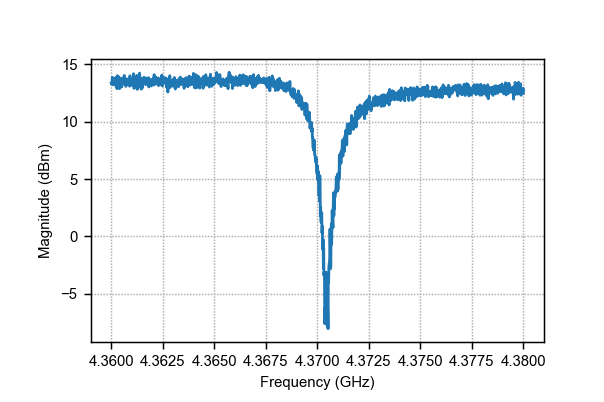

In [10]:
setup_frq_sweep(fstart=(4.37-0.01)*1e9, fstop=(4.37+0.01)*1e9, fpts=1501, pwr=-50)
mag, phase = take_trace(plot=True)

In [11]:
vna.S21.autoscale()

# Take a single VNA trace

In [62]:
sweep_obj = vna_frequency_sweep_dB(fstart=4.365e9, fstop=4.375e9, fpts=10001, chan='S21')
result = do_experiment(f"VNA/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 106


In [85]:
sweep_obj = sweep(it,range(100))(vna_frequency_sweep_dB(fstart=4.368e9, fstop=4.372e9, fpts=10001, chan='S21'))
result = do_experiment(f"VNA_timesweep/{SAMPLE}", sweep_obj, live_plot=True)

Starting experimental run with id: 115


# Power dependence

In [ ]:
vna.S21.avg(10)

In [ ]:
starts = [4.355e9, 3.7555e9, 3.543e9, 3.159e9, 3.0e9]
spans = 4 * [40e6] + [2e9]

for f0, fspan in zip(starts, spans):
    sweep_obj = sweep(vna.S21.power, np.arange(-60., -9., 5.))(
        vna_trace(fstart=f0, fstop=f0+fspan, fpts=4001, chan='S21', bw=1e3)
    )
    result = do_experiment(f"VNA_powersweep/{SAMPLE}", sweep_obj, live_plot=True)

# TWPA pump tune up

## VNA as function of pump power

In [ ]:
sweep_obj = sweep(twpa_pump.power, np.arange(2.5, 8.5, .2))(
    vna_trace(fstart=2e9, fstop=7e9, fpts=1001, chan='S21', navgs=1)
)

result = do_experiment(f"VNA_vs_pump_power/{SAMPLE}", sweep_obj, live_plot=True)

## VNA as function of pump frq

In [ ]:
sweep_obj = sweep(twpa_pump.frequency, np.arange(7.7e9, 8.4e9, 10e6))(
    vna_trace(fstart=2e9, fstop=7e9, fpts=1001, chan='S21', navgs=1)
)

result = do_experiment(f"VNA_vs_pump_frequency/{SAMPLE}", sweep_obj, live_plot=True)

## SNR as function of pump params

In [ ]:
twpa_pump.on()
vna.S21.avg(1)
vna.S21.power(-50)
setup_zerospan_trace(4.5e9, 201)


sweep_obj = sweep(twpa_pump.frequency, np.arange(7.95e9, 8.05e9, 0.5e6))(
    sweep(twpa_pump.power, np.arange(0.0, 12.0, .1)))(
        measure(get_SNR)
)

result = do_experiment(f"TWPA_SNR/{SAMPLE}", sweep_obj, live_plot=True)

# VNA vs Magnet Measurements

## Step 1: play with magnet

In [12]:
mgnt.IDN()

{'firmware': '2.6.04.000',
 'model': 'MERCURY IPS',
 'serial': '123550029',
 'vendor': 'OXFORD INSTRUMENTS'}

In [13]:
mgnt.GRPX.field_ramp_rate(4e-3)
mgnt.GRPY.field_ramp_rate(4e-3)
mgnt.GRPZ.field_ramp_rate(4e-3)

dr, dphi, dtheta = +0.001, +0, +0
for i in range(10):
    r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
    r1, phi1, theta1 = r+dr, phi+dphi, theta+dtheta
    mgnt.r_target(r1)
    mgnt.phi_target(phi1)
    mgnt.theta_target(theta1)
    mgnt.ramp(mode='safe')
    
    time.sleep(0.1)
    r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
    print(f'Magnet reached (r, phi, theta) = ({r}, {phi}, {theta})', end='\r')
    time.sleep(0.1)
    

spinning: [-0.0034, 0.0, 0.021]
spinning: [-0.0034, 0.0, 0.021]
spinning: [-0.0034, 0.0, 0.021]
spinning: [-0.0034, 0.0, 0.021]
spinning: [-0.0034, 0.0, 0.021]
spinning: [-0.0034, -0.0, 0.021]
spinning: [-0.0034, 0.0, 0.021]
spinning: [-0.0034, 0.0, 0.021]
spinning: [-0.0034, -0.0, 0.021]
spinning: [-0.0034, -0.0, 0.021]
spinning: [-0.0034, -0.0, 0.021]
spinning: [-0.0034, -0.0, 0.021]
spinning: [-0.0035, 0.0, 0.021]
spinning: [-0.0035, 0.0, 0.021]
spinning: [-0.0035, -0.0, 0.021]
spinning: [-0.0036, -0.0, 0.021]
spinning: [-0.0036, 0.0, 0.021]
spinning: [-0.0036, 0.0, 0.021]
spinning: [-0.0036, 0.0, 0.021]
spinning: [-0.0036, 0.0, 0.021]
spinning: [-0.0036, 0.0, 0.021]
spinning: [-0.0036, 0.0, 0.021]
spinning: [-0.0036, 0.0, 0.021]
spinning: [-0.0036, 0.0, 0.0209]
spinning: [-0.0036, -0.0, 0.0212](0.021207781590727493, -180.0, 9.727578551401587)
spinning: [-0.0036, -0.0, 0.0212]
spinning: [-0.0036, -0.0, 0.0212]
spinning: [-0.0036, -0.0, 0.0212]
spinning: [-0.0036, -0.0, 0.0213]
spinn

spinning: [-0.0044, -0.0, 0.0295](0.029628533544541147, -180.0, 8.540327655839526)
spinning: [-0.0044, -0.0, 0.0295]
spinning: [-0.0044, -0.0, 0.0295]
spinning: [-0.0044, -0.0, 0.0295]
spinning: [-0.0044, -0.0, 0.0295]
spinning: [-0.0044, -0.0, 0.0295]
spinning: [-0.0044, 0.0, 0.0295]
spinning: [-0.0044, 0.0, 0.0295]
spinning: [-0.0044, 0.0, 0.0295]
spinning: [-0.0044, 0.0, 0.0295]
spinning: [-0.0044, -0.0, 0.0294]
spinning: [-0.0044, -0.0, 0.0294]
spinning: [-0.0044, -0.0, 0.0294]
spinning: [-0.0044, 0.0, 0.0294]
spinning: [-0.0045, 0.0, 0.0293]
spinning: [-0.0045, 0.0, 0.0293]
spinning: [-0.0045, 0.0, 0.0293]
spinning: [-0.0045, -0.0, 0.0293]
spinning: [-0.0046, -0.0, 0.0292]
spinning: [-0.0046, 0.0, 0.0292]
spinning: [-0.0046, 0.0, 0.0292]
spinning: [-0.0046, 0.0, 0.0292]
spinning: [-0.0046, 0.0, 0.0292]
spinning: [-0.0046, 0.0, 0.0292]
spinning: [-0.0046, 0.0, 0.0292]
spinning: [-0.0046, 0.0, 0.0292]
spinning: [-0.0046, -0.0, 0.0291]
spinning: [-0.0046, 0.0, 0.0292]
spinning: [-0.0

In [115]:
r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
print(f'Magnet reached (r, phi, theta) = ({r}, {phi}, {theta})', end='\r')

In [14]:
mgnt.r_target(0.014)

In [18]:
mgnt.x_target(-0.0019)

In [19]:
mgnt.ramp(mode='simul')

In [ ]:
%debug

> d:\onedrive\bf2\code\qcodes\qcodes\instrument_drivers\oxford\mercuryips_visa.py(356)_ramp_safely()
    354             else:
    355                 while slave.ramp_status() == 'TO SET':
--> 356                     time.sleep(0.1)
    357 
    358     def set_new_field_limits(self, limit_func: Callable) -> None:

ipdb> slave.ramp_status()
'HOLD'
ipdb> exit


## Optimizing the field orientation

### tool functions

In [12]:
def get_trace_min(frqvals, trace):
    return frqvals[np.argmin(trace)], trace[np.argmin(trace)]

def find_frequency(frqvals, trace, method=get_trace_min, plot=False):
    f0, y0 = method(frqvals, trace)
    
    if plot:
        fig, ax = plt.subplots(1,1)
        ax.plot(frqvals, trace, 'o-', mfc='None', mew=0.5, lw=0.5)
        ax.grid(dashes=[1,1])
        ax.set_xlabel('Frequency')
        ax.set_ylabel('S21 (dBm)')
        r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
        ax.set_title('B = %.3f, phi = %.1f, theta = %.1f' %(r, phi, theta))
        
        ax.plot([f0], [y0], '*', ms=10, mew=1, mfc='None')
        
    return f0

# def step_field_spherical(dr, dphi, dtheta, nsteps):
#     pass

<IPython.core.display.Javascript object>


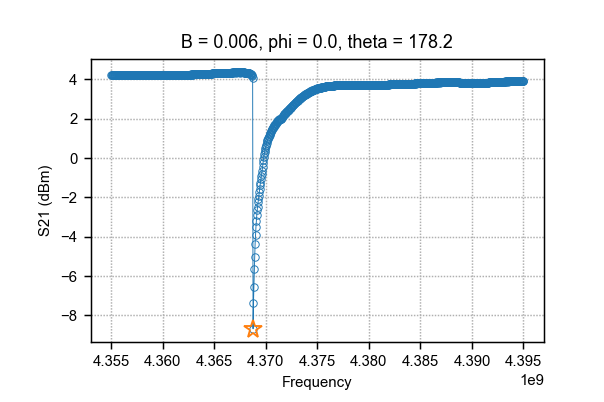

In [13]:
fstart = 4.375e9 - 20e6
fstop = fstart + 40e6
fvals = setup_frq_sweep(fstart, fstop, 1001)
trace = 20*np.log10(take_trace()[0])

f0 = find_frequency(fvals, trace, plot=True)

In [42]:
mgnt.r_target(0)
mgnt.ramp(mode='safe')

In [96]:
r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
print(f'Magnet reached (r, phi, theta) = ({r}, {phi}, {theta})', end='\r')

<IPython.core.display.Javascript object>


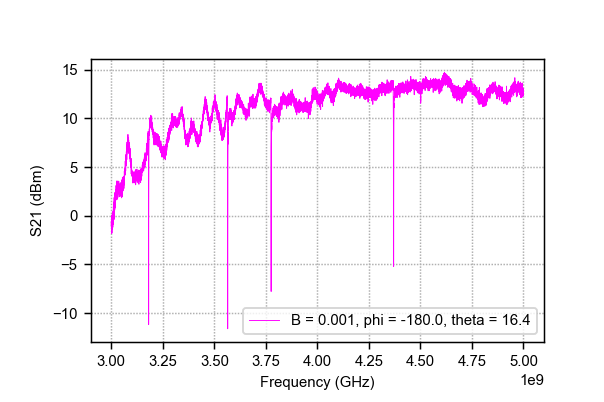

0


In [97]:
fstart = 3e9 
fstop = 5e9
fvals = setup_frq_sweep(fstart, fstop, 10001, navgs=1, pwr=-50)
mgnt.GRPX.field_ramp_rate(4e-3)
mgnt.GRPY.field_ramp_rate(4e-3)
mgnt.GRPZ.field_ramp_rate(4e-3)
dr, dphi, dtheta = -0.001, +0.0, 0.0
fig, ax = plt.subplots(1,1)
mgnt.ramp(mode='safe')
print(f'Magnet reached (r, phi, theta) = ({r}, {phi}, {theta})', end='\r')
for i in range(1):
    print(i)
    r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
    r1, phi1, theta1 = r+dr, phi+dphi, theta+dtheta
    mgnt.r_target(r1)
    mgnt.phi_target(phi1)
    mgnt.theta_target(theta1)
    mgnt.ramp(mode='safe')
    
    time.sleep(0.1)
    trace = 20*np.log10(take_trace()[0])
    ax.plot(fvals, trace, '-', mfc='None', mew=0.5, lw=0.5, color = (1,0,1-0.1*i), label='B = %.3f, phi = %.1f, theta = %.1f' %(r1, phi1, theta1))
    r, phi, theta = mgnt.r_measured(), mgnt.phi_measured(), mgnt.theta_measured()
    time.sleep(0.1)
    
ax.grid(dashes=[1,1])
ax.set_ylabel('S21 (dBm)')
ax.set_xlabel('Frequency (GHz)')
ax.legend()

In [87]:
mgnt.theta_measured()

19.366550229641177

In [90]:
r2, phi2, theta2 = r1, phi1, theta1

In [91]:
fvals2 = fvals
trace2 = trace

<IPython.core.display.Javascript object>


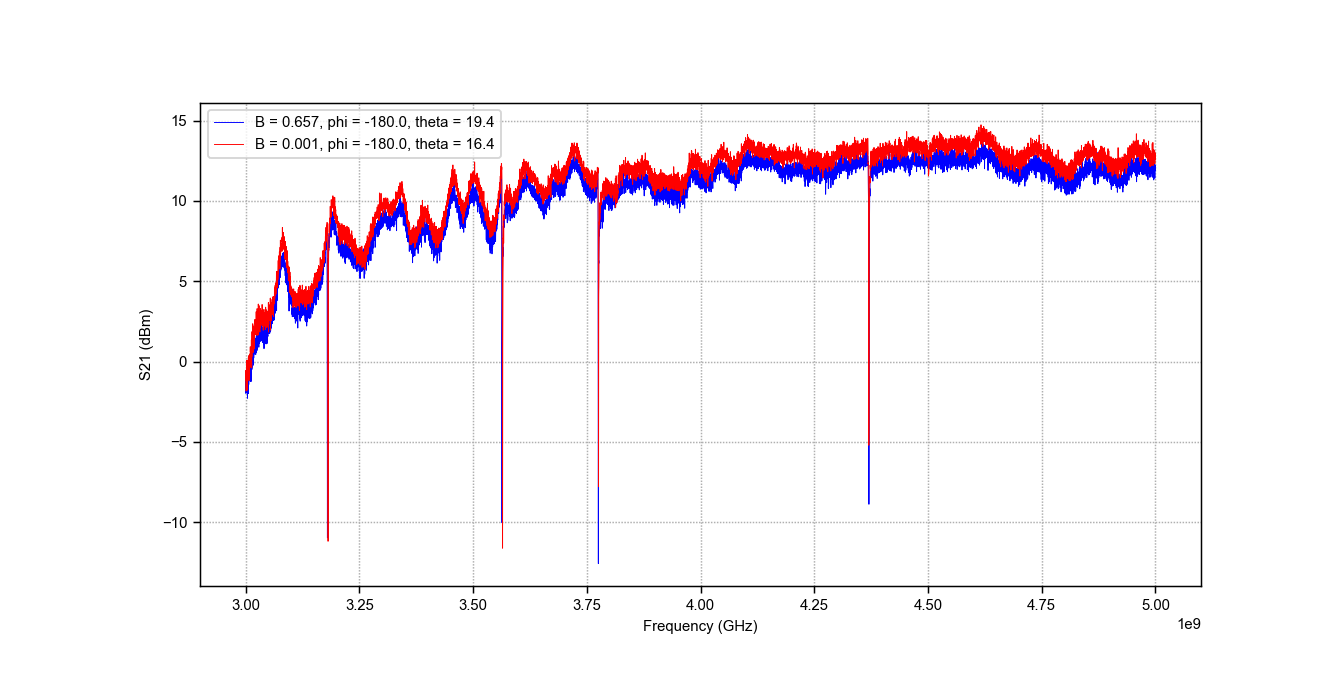

In [104]:
fig, ax = plt.subplots(1,1)
ax.plot(fvals2, trace2, '-', mfc='None', mew=0.5, lw=0.5, color='b', label='B = %.3f, phi = %.1f, theta = %.1f' %(r2, phi2, theta2))
ax.plot(fvals, trace, '-', mfc='None', mew=0.5, lw=0.5, color='r', label='B = %.3f, phi = %.1f, theta = %.1f' %(r1, phi1, theta1))

ax.grid(dashes=[1,1])
ax.set_ylabel('S21 (dBm)')
ax.set_xlabel('Frequency (GHz)')
ax.legend()    

In [106]:
mgnt.r_measured()

0.00072801098892805183